In [1]:
import datetime
import QuantLib as ql
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument('headless')  #화면안나d오게

In [2]:
def GET_DATE():
    date = ql.Date().todaysDate()
    one_day = ql.Period(1, ql.Days)
    last_bday = date - one_day
    
    us = ql.UnitedStates()
    
    while us.isBusinessDay(last_bday) == False:
        last_bday -= one_day
        
    date = datetime.date(last_bday.year(),
                         last_bday.month(),
                         last_bday.dayOfMonth())
    
    return date

eval_date = GET_DATE()

In [2]:
def GET_DATE():
    date = ql.Date().todaysDate() 
    one_day = ql.Period(1, ql.Days)  
    last_bday = date - one_day #오늘에서 하루 전 날짜.
    
    us = ql.UnitedStates()
    
    while us.isBusinessDay(last_bday) == False:
        last_bday -= one_day
    
    date = datetime.date(last_bday.year(),
                         last_bday.month(),
                         last_bday.dayOfMonth())
    
    return date

if __name__ == '__main__':   
    # 파이참같은 툴에서 코드작성할 때, 작성한 파일을 테스트목적으로 직접 실행할 때
    # 그럴 때는 이 아래의 코드가 실행됨
    # 그러나 이 py파일을 다른 코드에서 땡겨서 쓸 때에는 if 이하의 코드가 실행되지 않음
    
    eval_date = GET_DATE()

In [3]:
eval_date #오늘말고 직전 영업일이 언제냐

datetime.date(2021, 8, 9)

https://www.wsj.com/market-data/bonds

5year : https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD05Y?mod=md_bond_overview_quote

In [4]:
def GET_QUOTE(eval_date):
    driver = webdriver.Chrome('C:/jupyter_project/chromedriver.exe', options=options)
    tenors = ['01M','03M','06M','01Y','02Y','03Y','05Y','07Y','10Y','30Y']
    # 물론 시장에 있는 채권 다 가져와서 금리커브 만들 수도 잇겠지만
    # 보통은 위처럼 주로 거래되는 놈들로만 만듦
    
    maturities = []
    days = []
    prices = []
    coupons = []
    
    links = "https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD{}?mod=md_bond_overview_quote"
    
    for i, tenor in enumerate(tenors):
        driver.get(links.format(tenor))
        html = driver.page_source  # 소스코드 저장
        soup = BeautifulSoup(html, 'html.parser')
        
        #price
        if i <= 3:  # 1년까지가지고옴 / 단기쪽이면 그냥 금리가지고 오고
            data_src = soup.find('span', id='quote_val')
            price = data_src.text # 0.094% (텍스트)
            price = float(price[:-1])
        else:   #2년이상은 100단위로 quote함
            data_src = soup.find('span', id='price_quote_val') #2/32 이런거
            price = data_src.text # 100 0/32 (텍스트)
            price1 = float(price.split()[0])
            price2, price3 = price.split()[1].split('/')[0], price.split()[1].split('/')[1]
            price2, price3 = float(price2), float(price3)
            price = price1 + (price2/price3)
    
        # Coupon
        data_src2 = soup.find_all("span", {'class':"data_data"})
        coupon = data_src2[2].text
        if coupon != '': #쿠폰이 있으면
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
            
        # Maturity Date
        maturity = data_src2[3].text
        #텍스트를 datetime 객체로
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y').date()
        
        
        days.append((maturity - eval_date).days)  #만기와 평가일의 차이
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
        
    
    #데이터프레임 만들기
    df = pd.DataFrame([maturities, days, prices, coupons]).T
    headers = ['maturity','days','price','coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)  #만기일이 index
    return df
        
        

In [5]:
rate_tabel = GET_QUOTE(eval_date)
rate_tabel

,days,price,coupon
maturity,,,
2021-09-07,29,0.048,0.0
2021-11-04,87,0.058,0.0
2022-02-03,178,0.058,0.0
2022-07-14,339,0.081,0.0
2023-07-31,721,99.25,0.125
2024-07-15,1071,99.28125,0.375
2026-07-31,1817,99.09375,0.625
2028-07-31,2548,99.125,1.0
2031-05-15,3566,102.3125,1.625


In [23]:
#얘를 활용해서, spot curve와 할인 curve를 만들어야함

def TREASURY_CURVE(eval_date, rate_table):

    # Divide Quotes 테이블을 무이표채 /이표채로 나눈다.
    #미국단기 : 무이표채
    tbill = rate_table[0:4]
    tbond = rate_table[4:]

    # Set Evaluation Date
    eval_date = ql.Date(eval_date.day, eval_date.month, eval_date.year)
    # 평가일을 특정일로 설정하곘다고 Global하게 선연
    ql.Settings.instance().evaluationDate = eval_date

    # Set Market Convention
    # 미국 국채가 거래되는 시장관행 설정 (한국은 좀 다름)
    # 커브 헬퍼에 필요한 컨벤션 완성.
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    dayCounter = ql.ActualActual()  # 미국은 Act/Act방식 씀
    endOfMonth = False  # 거래일이 월말일때, 나중의 이자지급일을 웜말로 할거니?
    fixingDays = 1  # 다음 이자지급 구간에 적용되는 금리가 오늘 설정할 것인가...
    # 오늘부터 6개월동안의 이자지급구간에 해닫되는 이자 금리를 설정할 떄
    # 오늘에 해당하는 이자금리를 쓸 것인가. 아니면 하루 전에 미리 fixing을 할 것인가.
    # 아니면 2일전에...
    faceAmount = 100  # 액면가가 미국국채는 100달러 기준
    frequency = ql.Period(ql.Semiannual)
    dateGeneration = ql.DateGeneration.Backward

    # COnstruct T-Bill helpers
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(price/100.0)),
                                         ql.Period(maturity, ql.Days),
                                         fixingDays,
                                         calendar,
                                         convention,
                                         endOfMonth,
                                         dayCounter)
                    for price, maturity in zip(tbill['price'], tbill['days'])]
    # price는 rate_table에서 0.001, 0.1 이런것들. 얘네는 지금 %단위이므로 100으로 나눠줌
    # ql.Period()는 만기. maturity는 rate_table에서 days에 해당.

    # Construct T-Bond Helpers
    bond_helpers = []
    for price, coupon, maturity in zip(tbond['price'], tbond['coupon'], tbond['days']):
        maturity_date = eval_date + ql.Period(maturity, ql.Days)
        schedule = ql.Schedule(
            eval_date,  # 평가일자, 거래발생일자
            maturity_date,
            frequency,  # 일년에 2번
            calendar,
            convention,  # 이자발생일수에 대한 컨벤션
            convention,  # 원금상환일에 대한 컨벤션
            dateGeneration,  # 이자일수 발생 방식
            endOfMonth)
        bond_helper = ql.FixedRateBondHelper(
            ql.QuoteHandle(
                ql.SimpleQuote(price)),
            fixingDays,
            faceAmount,
            schedule,
            [coupon/100.0],  # 여기의 coupon값도 %값이므로 100으로 나눠줌
            dayCounter,
            convention
        )
        bond_helpers.append(bond_helper)

    # Bind Helpers
    rate_helper = bill_helpers + bond_helpers

    # Build Curve
      # TermStructure 클래스
    curve = ql.PiecewiseLinearZero(eval_date,
                                  rate_helper,
                                  dayCounter)
    
    return curve

In [24]:
curve = TREASURY_CURVE(eval_date, rate_tabel)

In [28]:
dir(curve)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__weakref__',
 'allowsExtrapolation',
 'calendar',
 'dates',
 'dayCounter',
 'disableExtrapolation',
 'discount',
 'enableExtrapolation',
 'forwardRate',
 'maxDate',
 'maxTime',
 'nodes',
 'referenceDate',
 'this',
 'thisown',
 'timeFromReference',
 'times',
 'zeroRate']

In [27]:
def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    discount_factor = curve.discount(date)
    return discount_factor

In [29]:
def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    dayCount = ql.ActualActual()
    compounding = ql.Compounded  #채권의 가장 일반적인 Convention
    frequency = ql.Continuous    #Compound 방식 / 연속복리로 zerorate 계산
    zero_rate = curve.zeroRate(date, dayCount, compounding, frequency).rate()
    return zero_rate

In [30]:
rate_tabel

,days,price,coupon
maturity,,,
2021-08-24,26,0.045,0.0
2021-10-28,91,0.051,0.0
2022-01-27,182,0.052,0.0
2022-07-14,350,0.068,0.0
2023-07-31,732,99.25,0.125
2024-07-15,1082,100.0,0.375
2026-07-31,1828,99.15625,0.625
2028-06-30,2528,99.25,1.25
2031-05-15,3577,103.125,1.625


In [35]:
rate_tabel['discount factor'] = np.nan
rate_tabel['zero rate'] = np.nan

for date in rate_tabel.index:
    rate_tabel.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
    rate_tabel.loc[date, 'zero rate'] = ZERO_RATE(date, curve)

In [39]:
rate_tabel.drop(['dicount factor'], axis=1, inplace=True)

In [41]:
rate_tabel

,days,price,coupon,discount factor,zero rate
maturity,,,,,
2021-08-24,26,0.045,0.0,0.999968,0.000450
2021-10-28,91,0.051,0.0,0.999880,0.000482
2022-01-27,182,0.052,0.0,0.999744,0.000513
2022-07-14,350,0.068,0.0,0.999450,0.000574
2023-07-31,732,99.25,0.125,0.990003,0.005016
2024-07-15,1082,100.0,0.375,0.988961,0.003750
2026-07-31,1828,99.15625,0.625,0.960750,0.008016
2028-06-30,2528,99.25,1.25,0.908610,0.013894
2031-05-15,3577,103.125,1.625,0.880562,0.013029


- 할인계수가 점점 작아지는 건 당연. 멀리 있는 놈일수록 기나긴 시간동안 할인을 해줘야 하므로...
- zero rate는 discount factor와 역수 관계

**시각화**

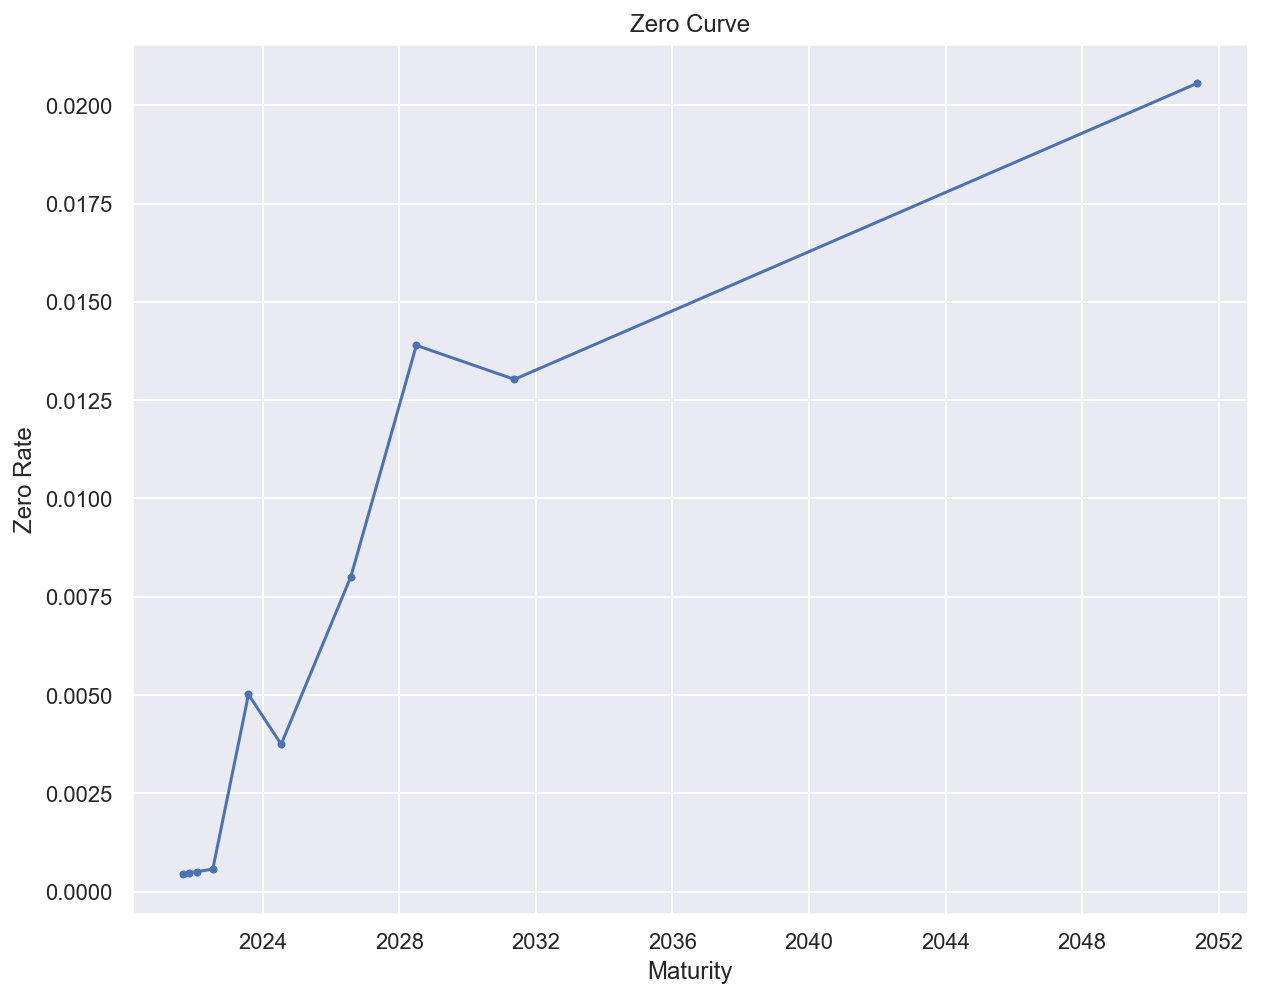

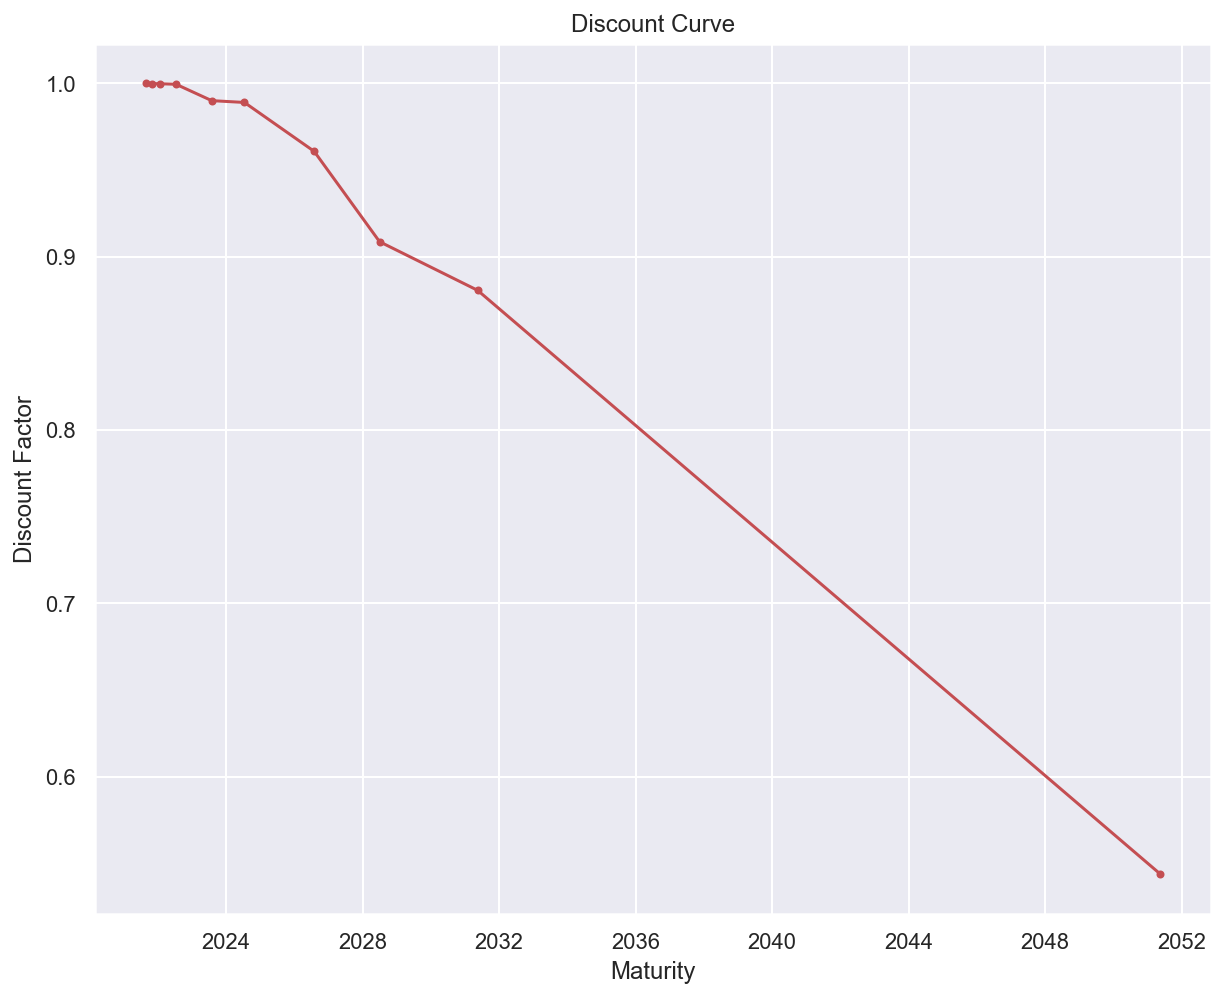

In [43]:

# 스팟금리 커브
plt.figure(figsize=(10,8))
plt.plot(rate_tabel['zero rate'], 'b.-')
plt.title('Zero Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Zero Rate')

plt.figure(figsize=(10,8))
plt.plot(rate_tabel['discount factor'], 'r.-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')

plt.show()

In [44]:
%%writefile bond_curve.py
import datetime
import QuantLib as ql
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument('headless')  #화면안나d오게

def GET_DATE():
    date = ql.Date().todaysDate() 
    one_day = ql.Period(1, ql.Days)  
    last_bday = date - one_day #오늘에서 하루 전 날짜.
    
    us = ql.UnitedStates()
    
    while us.isBusinessDay(last_bday) == False:
        last_bday -= one_day
    
    date = datetime.date(last_bday.year(),
                         last_bday.month(),
                         last_bday.dayOfMonth())
    
    return date

def GET_QUOTE(eval_date):
    driver = webdriver.Chrome('C:/jupyter_project/chromedriver.exe', options=options)
    tenors = ['01M','03M','06M','01Y','02Y','03Y','05Y','07Y','10Y','30Y']
    # 물론 시장에 있는 채권 다 가져와서 금리커브 만들 수도 잇겠지만
    # 보통은 위처럼 주로 거래되는 놈들로만 만듦
    
    maturities = []
    days = []
    prices = []
    coupons = []
    
    links = "https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD{}?mod=md_bond_overview_quote"
    
    for i, tenor in enumerate(tenors):
        driver.get(links.format(tenor))
        html = driver.page_source  # 소스코드 저장
        soup = BeautifulSoup(html, 'html.parser')
        
        #price
        if i <= 3:  # 1년까지가지고옴 / 단기쪽이면 그냥 금리가지고 오고
            data_src = soup.find('span', id='quote_val')
            price = data_src.text # 0.094% (텍스트)
            price = float(price[:-1])
        else:   #2년이상은 100단위로 quote함
            data_src = soup.find('span', id='price_quote_val') #2/32 이런거
            price = data_src.text # 100 0/32 (텍스트)
            price1 = float(price.split()[0])
            price2, price3 = price.split()[1].split('/')[0], price.split()[1].split('/')[1]
            price2, price3 = float(price2), float(price3)
            price = price1 + (price2/price3)
    
        # Coupon
        data_src2 = soup.find_all("span", {'class':"data_data"})
        coupon = data_src2[2].text
        if coupon != '': #쿠폰이 있으면
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
            
        # Maturity Date
        maturity = data_src2[3].text
        #텍스트를 datetime 객체로
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y').date()
        
        
        days.append((maturity - eval_date).days)  #만기와 평가일의 차이
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
        
    
    #데이터프레임 만들기
    df = pd.DataFrame([maturities, days, prices, coupons]).T
    headers = ['maturity','days','price','coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)  #만기일이 index
    return df
        
#얘를 활용해서, spot curve와 할인 curve를 만들어야함

def TREASURY_CURVE(eval_date, rate_table):

    # Divide Quotes 테이블을 무이표채 /이표채로 나눈다.
    #미국단기 : 무이표채
    tbill = rate_table[0:4]
    tbond = rate_table[4:]

    # Set Evaluation Date
    eval_date = ql.Date(eval_date.day, eval_date.month, eval_date.year)
    # 평가일을 특정일로 설정하곘다고 Global하게 선연
    ql.Settings.instance().evaluationDate = eval_date

    # Set Market Convention
    # 미국 국채가 거래되는 시장관행 설정 (한국은 좀 다름)
    # 커브 헬퍼에 필요한 컨벤션 완성.
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    dayCounter = ql.ActualActual()  # 미국은 Act/Act방식 씀
    endOfMonth = False  # 거래일이 월말일때, 나중의 이자지급일을 웜말로 할거니?
    fixingDays = 1  # 다음 이자지급 구간에 적용되는 금리가 오늘 설정할 것인가...
    # 오늘부터 6개월동안의 이자지급구간에 해닫되는 이자 금리를 설정할 떄
    # 오늘에 해당하는 이자금리를 쓸 것인가. 아니면 하루 전에 미리 fixing을 할 것인가.
    # 아니면 2일전에...
    faceAmount = 100  # 액면가가 미국국채는 100달러 기준
    frequency = ql.Period(ql.Semiannual)
    dateGeneration = ql.DateGeneration.Backward

    # COnstruct T-Bill helpers
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(price/100.0)),
                                         ql.Period(maturity, ql.Days),
                                         fixingDays,
                                         calendar,
                                         convention,
                                         endOfMonth,
                                         dayCounter)
                    for price, maturity in zip(tbill['price'], tbill['days'])]
    # price는 rate_table에서 0.001, 0.1 이런것들. 얘네는 지금 %단위이므로 100으로 나눠줌
    # ql.Period()는 만기. maturity는 rate_table에서 days에 해당.

    # Construct T-Bond Helpers
    bond_helpers = []
    for price, coupon, maturity in zip(tbond['price'], tbond['coupon'], tbond['days']):
        maturity_date = eval_date + ql.Period(maturity, ql.Days)
        schedule = ql.Schedule(
            eval_date,  # 평가일자, 거래발생일자
            maturity_date,
            frequency,  # 일년에 2번
            calendar,
            convention,  # 이자발생일수에 대한 컨벤션
            convention,  # 원금상환일에 대한 컨벤션
            dateGeneration,  # 이자일수 발생 방식
            endOfMonth)
        bond_helper = ql.FixedRateBondHelper(
            ql.QuoteHandle(
                ql.SimpleQuote(price)),
            fixingDays,
            faceAmount,
            schedule,
            [coupon/100.0],  # 여기의 coupon값도 %값이므로 100으로 나눠줌
            dayCounter,
            convention
        )
        bond_helpers.append(bond_helper)

    # Bind Helpers
    rate_helper = bill_helpers + bond_helpers

    # Build Curve
      # TermStructure 클래스
    curve = ql.PiecewiseLinearZero(eval_date,
                                  rate_helper,
                                  dayCounter)
    
    return curve   

def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    discount_factor = curve.discount(date)
    return discount_factor

def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    dayCount = ql.ActualActual()
    compounding = ql.Compounded  #채권의 가장 일반적인 Convention
    frequency = ql.Continuous    #Compound 방식 / 연속복리로 zerorate 계산
    zero_rate = curve.zeroRate(date, dayCount, compounding, frequency).rate()
    return zero_rate

Writing bond_curve.py
